In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import zipfile
import shutil
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import random
import matplotlib.image as mpimg
import random
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
source_path = '/content/drive/My Drive/SOI_SDS'

In [4]:
destination_folder = '/content/zip'

In [5]:
import shutil
shutil.copytree(source_path, destination_folder)

'/content/zip'

In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/train_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [7]:
zip_ref = zipfile.ZipFile("/content/zip/test_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [8]:
df = pd.read_csv('/content/drive/My Drive/SOI_SDS/train.csv')
df.head()

,File Name,Class
0,1.jpg,other
1,2.jpg,bright dune
2,3.jpg,other
3,4.jpg,crater
4,5.jpg,other


In [9]:
df.columns

Index(['File Name', 'Class'], dtype='object')

In [10]:
df['Class'].unique()

array(['other', 'bright dune', 'crater', 'slope streak', 'dark dune',
       'swiss cheese', 'spider', 'impact ejecta'], dtype=object)

In [11]:
import os
image_directory = '/content/train_dataset'
df['File Name'] = df['File Name'].apply(lambda x: os.path.join(image_directory, x))
df.to_csv('updated_file.csv', index=False)

In [12]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(df, num_images=4):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax in axs.flat:
        random_iloc = random.randint(0, len(df) - 1)
        random_image = df['File Name'][random_iloc]
        img = mpimg.imread(random_image)
        ax.imshow(img, cmap='gray')
        ax.set_title(df['Class'][random_iloc])
        ax.axis("off")
        print(f"Image shape: {img.shape}")
    plt.tight_layout()
    plt.show()

Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)


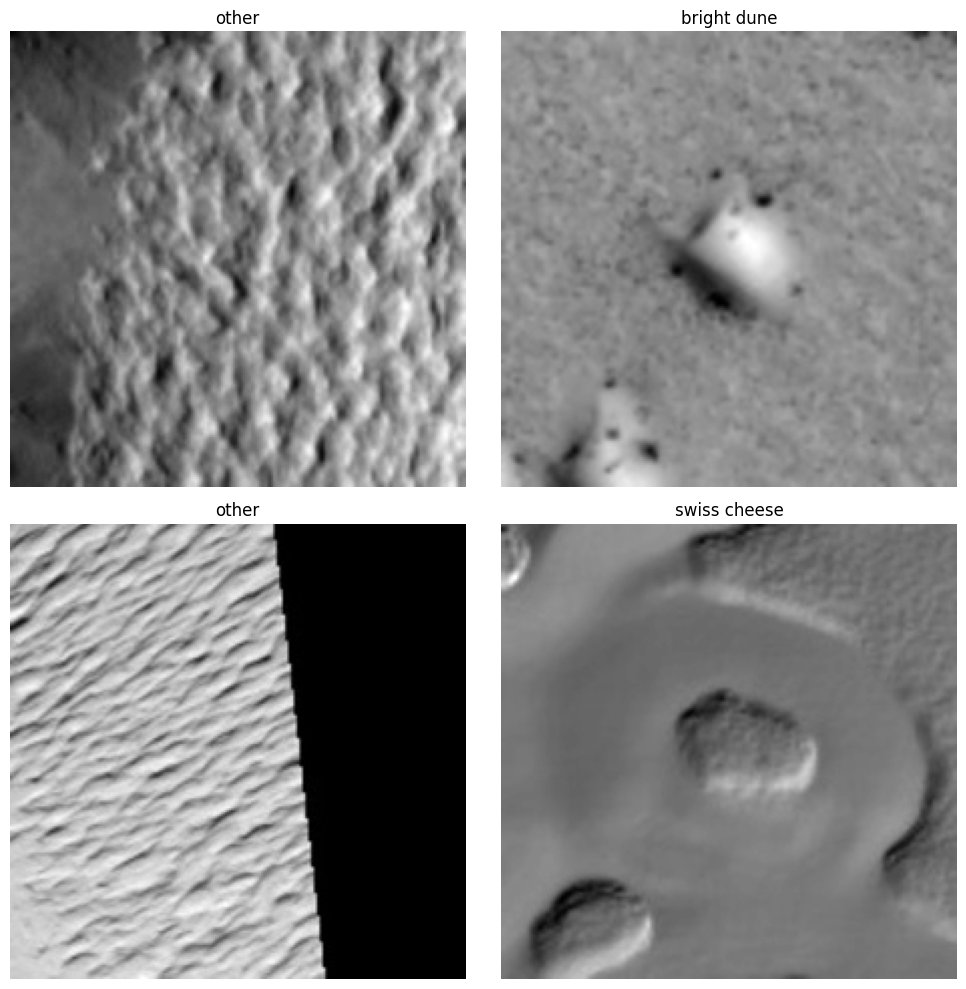

In [13]:
view_random_images(df)

In [14]:
input_csv='/content/updated_file.csv'
output_dir='Processed_aug_train_images'
output_csv='Augmented_Up_train.csv'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

labels_df=pd.read_csv(input_csv)
datagen=ImageDataGenerator( #For data augmentation
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def preprocess_image(image_path): #preprocessing the images.
    image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image_normalized=image/255.0
    image_blurred =cv2.GaussianBlur(image_normalized,(5,5),0)
    image_equalized=cv2.equalizeHist((image_blurred*255).astype(np.uint8))
    return image_equalized

def save_augmented_images(image,image_name,label, augment_count=5):
    augmented_data=[]
    image_expanded=np.expand_dims(image,axis=0)
    image_expanded= np.expand_dims(image_expanded,axis=-1)
    augmented_images =datagen.flow(image_expanded,batch_size=1)
    for i in range(augment_count):
        augmented_image=next(augmented_images)[0].astype(np.uint8)
        augmented_image=augmented_image.squeeze()
        augmented_filename=f"{os.path.splitext(image_name)[0]}_aug_{i}.png"
        output_path=os.path.join(output_dir,augmented_filename)
        cv2.imwrite(output_path,augmented_image)
        augmented_data.append({'File path': output_path, 'Class': label})
    return augmented_data

new_data = []
for index,row in labels_df.iterrows():
    image_path= row['File Name']
    label=row['Class']
    image_name= os.path.basename(image_path)
    processed_image=preprocess_image(image_path)
    processed_image_path=os.path.join(output_dir,image_name)
    cv2.imwrite(processed_image_path,processed_image)
    new_data.append({'File path': processed_image_path, 'Class': label})
    augmented_data=save_augmented_images(processed_image, image_name, label)
    new_data.extend(augmented_data)
augmented_labels_df=pd.DataFrame(new_data)
augmented_labels_df.to_csv(output_csv, index=False)
print(f"Processing, augmentation, and labeling completed.")
print(f"Total training data : f{len(augmented_labels_df)}")

Processing, augmentation, and labeling completed.
Total training data : f37206


Original Image shape: (227, 227)
Augmented Image 0 shape: (227, 227)
Augmented Image 1 shape: (227, 227)
Augmented Image 2 shape: (227, 227)
Augmented Image 3 shape: (227, 227)
Augmented Image 4 shape: (227, 227)


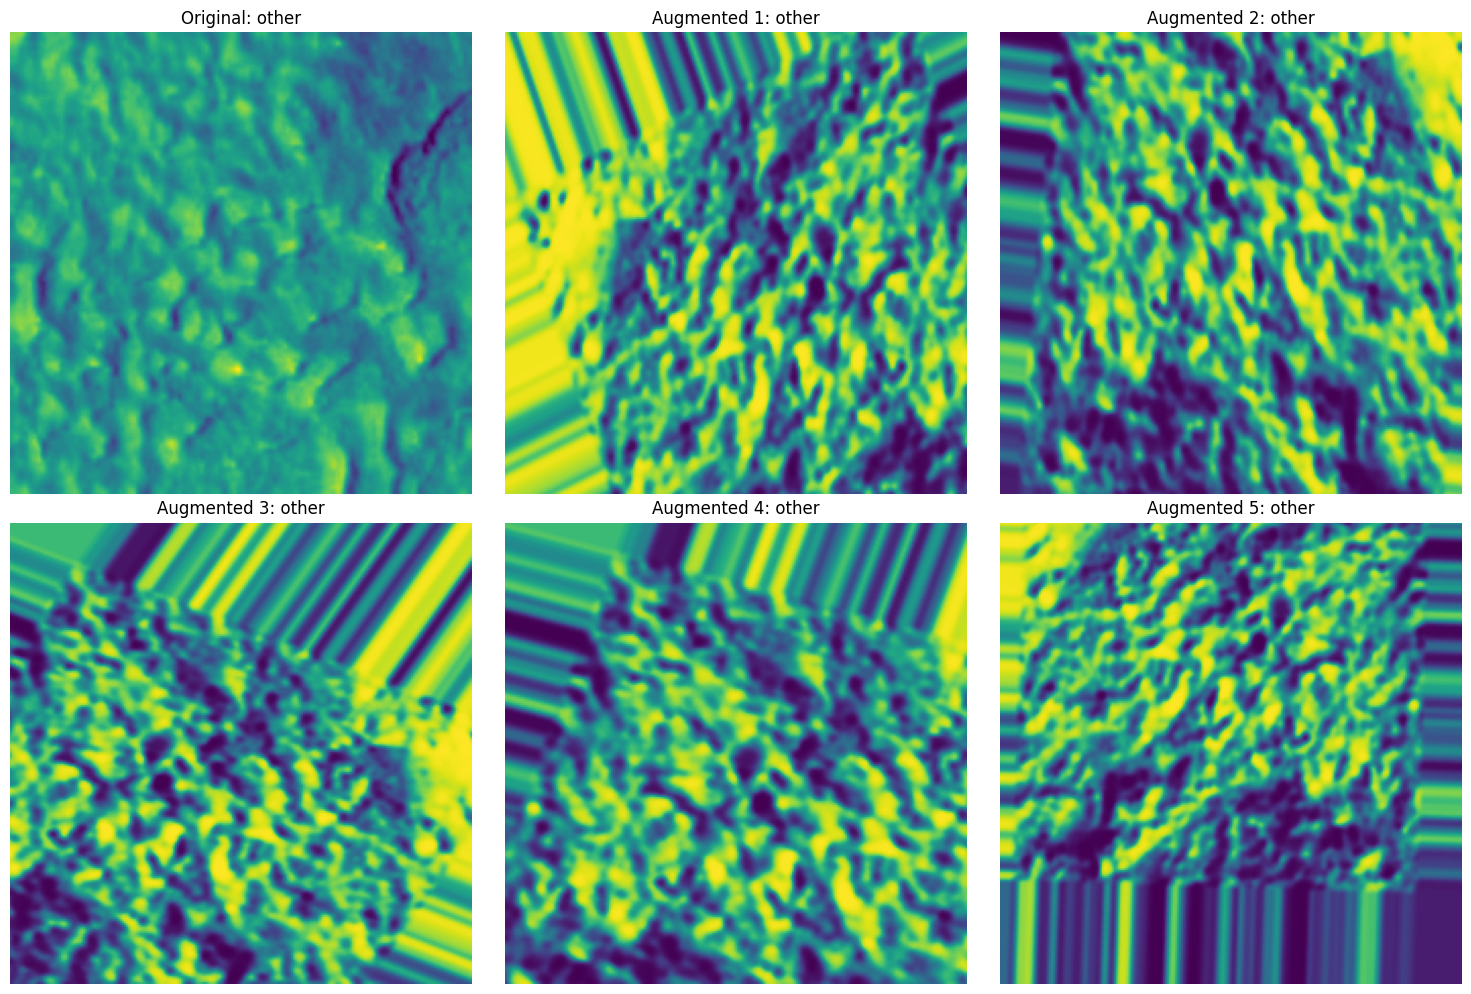

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(df):
    num_images=6
    fig,axs=plt.subplots(2,3,figsize=(15,10))
    axs=axs.flatten()
    random_iloc=random.randint(0,len(df)-1)
    random_image=df['File Name'][random_iloc]
    img=mpimg.imread(random_image)
    axs[0].imshow(img)
    axs[0].set_title(f"Original: {df['Class'][random_iloc]}")
    axs[0].axis("off")
    print(f"Original Image shape: {img.shape}")
    for i in range(1,num_images):
        loc=f'/content/Processed_aug_train_images/{random_iloc}_aug_{i-1}.png'
        img=mpimg.imread(loc)
        axs[i].imshow(img)
        axs[i].set_title(f"Augmented {i}: {df['Class'][random_iloc]}")
        axs[i].axis("off")
        print(f"Augmented Image {i-1} shape: {img.shape}")

    plt.tight_layout()
    plt.show()
view_random_images(df)

In [16]:
df=pd.read_csv('/content/Augmented_Up_train.csv')
train_df,test_df=train_test_split(df,test_size=0.1,random_state=1,shuffle=True)
print(f"Length of train data: {len(train_df)}")
print(f"Length of test data: {len(test_df)}")

Length of train data: 33485
Length of test data: 3721


In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [18]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='File path',
    y_col='Class',
    target_size=(227, 227),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

Found 33485 validated image filenames belonging to 8 classes.


In [19]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='File path',
    y_col='Class',
    target_size=(227, 227),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3721 validated image filenames belonging to 8 classes.


In [20]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable = False   # Freeze

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', input_shape=(227, 227, 1)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21139558 (80.64 MB)
Trainable params: 6424

In [25]:
history = model.fit(
    train_images,
    epochs=20,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/20
524/524 [==============================] - 362s 640ms/step - loss: 1.3562 - accuracy: 0.7282 - val_loss: 0.5098 - val_accuracy: 0.8334 - lr: 0.0010
Epoch 2/20
524/524 [==============================] - 319s 609ms/step - loss: 0.6351 - accuracy: 0.7992 - val_loss: 0.4330 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 3/20
524/524 [==============================] - 319s 609ms/step - loss: 0.5354 - accuracy: 0.8250 - val_loss: 0.4055 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/20
524/524 [==============================] - 319s 609ms/step - loss: 0.4679 - accuracy: 0.8429 - val_loss: 0.3726 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 5/20
524/524 [==============================] - 319s 609ms/step - loss: 0.4338 - accuracy: 0.8524 - val_loss: 0.4289 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 6/20
524/524 [==============================] - 319s 609ms/step - loss: 0.4027 - accuracy: 0.8583 - val_loss: 0.3699 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 7/20
524/524 [==========================

In [26]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.36077
Test Accuracy: 88.12%


In [27]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [28]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/test_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [29]:
test_image_directory = '/content/test_dataset'
csv_output_path = '/content/drive/My Drive/SOI_SDS/predictions_VGG16_with_data_augmentation.csv'

In [30]:
img_size = (227,227,1)

In [31]:
class_labels = list(test_images.class_indices.keys())

In [32]:
image_paths = []
predicted_labels = []

In [33]:
  for img_file in os.listdir(test_image_directory):
    img_path = os.path.join(test_image_directory, img_file)

    img = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_index]

    image_paths.append(img_path)
    predicted_labels.append(predicted_label)

1/1 [==============================] - 0s 21ms/step


In [34]:
results_df = pd.DataFrame({
    'Image_Path': image_paths,
    'Predicted_Label': predicted_labels
})

In [35]:
results_df.to_csv(csv_output_path, index=False)